# RESEARCH

# Outline


- [Task 1](#task-1): Classification with a Convolutional Neural Network <a name="index-task-1"></a>
  - [(1.1)](#task-11) <a name="index-task-11"></a>
  - [(1.2)](#task-12) <a name="index-task-12"></a>
  - [(1.3)](#task-13) <a name="index-task-13"></a>
- [Task 2](#task-2): Dimensionality Reduction: PCA vs ISOMAP <a name="index-task-2"></a>
  - [(2.1)](#task-21)
  - [(2.2)](#task-22)
  - [(2.3)](#task-23)  



---



<a name="task-1"></a>

# (1) Task 1: Classification with a Convolutional Neural Network [(index)](#index-task-1)

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import scipy
from scipy.sparse import linalg

# Importing losses, activation functions and layers from PyTorch 
from torch.nn import Sequential, CrossEntropyLoss, Conv2d, MaxPool2d, Flatten, Linear, ReLU, Softmax, Parameter
from torch.utils.data import TensorDataset, DataLoader

# Changing default font sizes
plt.rc('xtick', labelsize=8) # Tick labels
plt.rc('ytick', labelsize=8) # Tick labels
plt.rc('legend', fontsize=10) # Legend
plt.rc('axes', titlesize=15, labelsize=10) # Title and 'x' and 'y' labels

<a name="task-11"></a>

## (1.1) [(index)](#index-task-11)

In [2]:
X_train = np.load('star_images_train.npy')
Y_train = np.load('star_classes_train.npy')

x_testing = np.load('star_images_test.npy')
y_testing = np.load('star_classes_test.npy')

In [3]:
torch.manual_seed(61)

Define `set split` which splits the data set into training set and validation set using `np.random.choice`

In [4]:
def set_split(X_train, Y_train):
    
    rng_ind = np.random.choice(np.arange(X_train.shape[0]), int(X_train.shape[0]*0.75), replace=False)
    not_ind = [i for i in np.arange(X_train.shape[0]) if i not in rng_ind]

    x_train = X_train[rng_ind, :, :]
    x_test = X_train[not_ind, :, :]

    y_train = Y_train[rng_ind]
    y_test = Y_train[not_ind]
    
    return x_train, x_test, y_train, y_test

Split the training data set

In [5]:
x_train, x_val, y_train, y_val = set_split(X_train, Y_train)

`get_model` function implements a CNN architecture that contains the desired layers.

In [6]:
def get_model(x_train, f1, f2, k1, k2, pool_size, stride_pool, classes):
    """
    CNN model in PyTorch:
    - Layers are Conv2d(+ReLU), MaxPool2d, Flatten and Linear(+Softmax).
    - It features an Adam optimiser and CrossEntropyLoss criterion.

    Parameters:
    x_train: Training data
    n_filters: Number of filters to be used in the convolutional layer
    k: Kernel size in the convolutional layer
    pool_size: MaxPool1d window size
    stride_pool: Stride of the MaxPool2d sliding window
    classes: List containing the output classes

    Returns:
    Model, criterion and optimiser.

    """
    
    model = Sequential(
        Conv2d(1, f1, kernel_size=(k1, k1)),
        ReLU(),
        MaxPool2d(kernel_size=(pool_size, pool_size), stride=stride_pool),
        Conv2d(f1, f2, kernel_size=(k2, k2)),
        ReLU(),
        Flatten(),
        Linear(f2 * ((x_train.shape[1] - k1 + 1) // pool_size - k2 + 1) ** 2, len(classes)),
        Softmax(dim=1),
    )

    criterion = CrossEntropyLoss()
    optimiser = torch.optim.Adam(model.parameters())

    return model, criterion, optimiser

In [7]:
classes = [
    'O5V',
    'A0V',
    'F5V',
    'M5V'
]

create the model

In [8]:
f1 = 4
f2 = 8
k1 = 5
k2 = 5
pool_size = 2
stride_pool = 2

model, criterion, optimiser = get_model(x_train, f1, f2, k1, k2, pool_size, stride_pool, classes)
print(model)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=800, out_features=4, bias=True)
  (7): Softmax(dim=1)
)


`data_loader` prepares the data appropriatily for `training_loop`

In [9]:
def data_loader(x_train, y_train, shuffle, batch_size=128):

    # Numpy arrays to PyTorch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train)
    
    # Creating training and validation datasets
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor.squeeze())

    # Creating corresponding DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    
    return train_loader

In [10]:
train_loader = data_loader(x_train, y_train, True)

In [11]:
val_loader = data_loader(x_val, y_val, False)

In [12]:
class EarlyStopping:
    """
    EarlyStopping class.

    Attributes:
    max_patience: Amount of epochs with no improvement after which training is stopped.
    patience: Stores the number of epochs with no improvement.
    best_valid_loss: Stores the current value of the best (minimum) validation loss.
    early_stop: True if training needs to be stopped due to the early stopping condition being met.

    Methods:
    step(val_loss):
        Checks current state after an epoch and updates best_loss, patience and early_stop accordingly.
    """

    def __init__(self, max_patience=150):
        self.max_patience = max_patience
        self.patience = 0
        self.best_valid_loss = float('inf')
        self.early_stop = False

    def step(self, val_loss):
        if val_loss < self.best_valid_loss:
            self.best_valid_loss = val_loss
            self.patience = 0
        else:
            self.patience += 1
            if self.patience >= self.max_patience:
                self.early_stop = True

In [13]:
def training_loop(model, criterion, optimiser, train_loader, val_loader, max_num_epochs=2000, max_patience=150, printer=True, l2_reg=0):
    """
    Training loop with early stopping to monitor the validation accuracy.

    Parameters:
    train_loader: Training DataLoader
    val_loader: Validation DataLoader
    max_num_epochs: Maximum number of epochs
    max_patience: max_patience attribute of the EarlyStopping class

    Returns:
    Model, criterion and optimiser.

    """

    history = {'training_loss': [], 'validation_loss': [], 'training_accuracy': [], 'validation_accuracy': []}
    early_stopping = EarlyStopping(max_patience=max_patience)

    for epoch in range(max_num_epochs):

        tr_loss = 0.0
        tr_accuracy = 0
        val_loss = 0.0
        val_accuracy = 0

        # Training
        model.train()
        for inputs, labels in train_loader:
            optimiser.zero_grad()
            inputs = inputs.unsqueeze(1)# Setting gradients to zero
            
            # L2 Regularisation Implementation
            l2 = torch.tensor(0.0, requires_grad=True)
            l2 = 0
            
            for layer in model.children():
                if isinstance(layer, Conv2d):
                    l2 += torch.norm(layer.weight)
                    
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Divide the penlaty term by batch size when adding to the loss
            loss +=  l2 / labels.size(dim=0) * l2_reg
            
            tr_loss += loss.item()
            tr_accuracy += (torch.max(outputs, 1)[1] == labels).sum().item() / (len(train_loader) * labels.size(0))  ## <-- SOLUTION
            loss.backward() # Computes gradients of the loss
            optimiser.step() # Optimisation step (parameters are updated)

        history['training_loss'].append(tr_loss/len(train_loader))
        history['training_accuracy'].append(100*tr_accuracy)

        # Validation
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_accuracy += (torch.max(outputs, 1)[1] == labels).sum().item() / (len(val_loader) * labels.size(0))

        history['validation_loss'].append(val_loss/len(val_loader))
        history['validation_accuracy'].append(100*val_accuracy)

        # Calculate accuracy and print
        if printer==True:
            if epoch % 200 == 0:
                print(f"Epoch {epoch + 1}/{max_num_epochs}, Training loss: {tr_loss/len(train_loader)}, Training accuracy: {100*tr_accuracy}%, Validation loss: {val_loss/len(val_loader)}, Validation accuracy: {100*val_accuracy}%")

        # Check for early stopping
        early_stopping.step(val_loss / len(val_loader))
        if early_stopping.early_stop:
            print("Early stopping acting.")
            break

    return history


Call the training loop the train the model

In [14]:
history = training_loop(model, criterion, optimiser, train_loader, val_loader, 2000, 150)

Epoch 1/2000, Training loss: 1.3863936364650726, Training accuracy: 26.2905943627451%, Validation loss: 1.3861286640167236, Validation accuracy: 24.356617647058822%
Epoch 201/2000, Training loss: 1.1712488532066345, Training accuracy: 60.206035539215684%, Validation loss: 1.1807987689971924, Validation accuracy: 58.01930147058824%
Epoch 401/2000, Training loss: 1.0954323410987854, Training accuracy: 65.69393382352942%, Validation loss: 1.1000189781188965, Validation accuracy: 69.96783088235294%
Epoch 601/2000, Training loss: 1.0582921206951141, Training accuracy: 71.89414828431373%, Validation loss: 1.061890184879303, Validation accuracy: 76.42463235294117%
Epoch 801/2000, Training loss: 1.0284046232700348, Training accuracy: 76.8344056372549%, Validation loss: 1.0250635743141174, Validation accuracy: 78.37775735294117%
Epoch 1001/2000, Training loss: 0.9998763799667358, Training accuracy: 80.31173406862744%, Validation loss: 1.0030585527420044, Validation accuracy: 80.33088235294117%


Plot the loss and the classfication accuracy on the training and validation sets as a function of epochs.

Final Validation Accuracy is 81.50275735294117


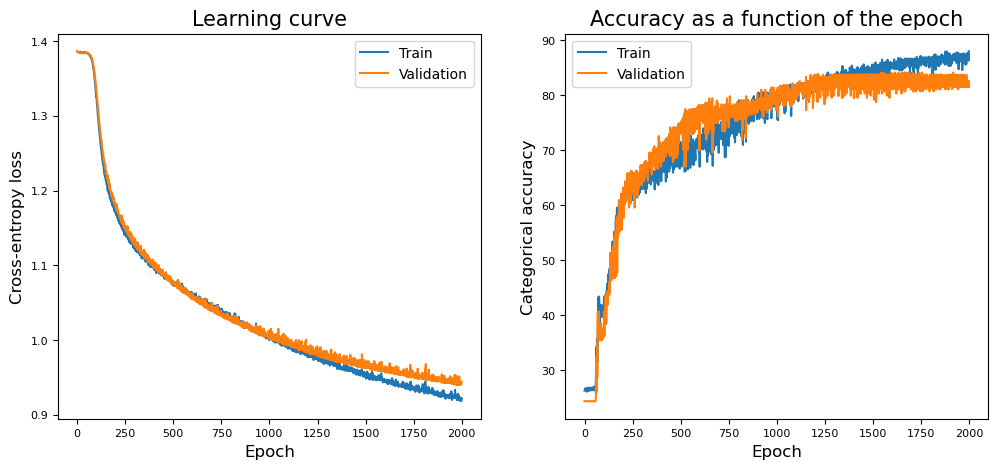

In [15]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history['training_loss'], label='Train')
plt.plot(history['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history['training_accuracy'], label='Train')
plt.plot(history['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

print(f"Final Validation Accuracy is {history['validation_accuracy'][-1]}")

plt.show()

As we can see from the loss plot, after approximately 250 epochs, there is the training loss decreases over epoch which indicates that the model that we created is learning the training data set. Furthermore, the plots slowly shows convergence towards the end, suggesting that the model is almost finished learning the data and further epochs will not make a huge difference. Overall, we see a similar trend in the validation set for both plots, suggesting that the model generalises well and there is little to no overfitting.

`testing_loader` is needed to evaluate the classfication accuarcy on the test set.

In [16]:
testing_loader = data_loader(x_testing, y_testing, False, batch_size=1)

`test_acc` evaluates the classification accuarcy on the test using the model trained above.

In [17]:
def test_acc(model, testing_loader):
    """
    
    Calculate the classification accuracy on the test set
    
    """
    
    val_accuracy = 0
    
    for inputs, labels in train_loader:
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            val_accuracy += ((torch.max(outputs, 1)[1] == labels).sum().item() / 
                              (len(train_loader) * labels.size(0)))
    
    print(f"The classification accuracy on the test set is {val_accuracy}")
    
    return val_accuracy

In [18]:
t_a = test_acc(model, testing_loader)

The classification accuracy on the test set is 0.8768382352941176


High classification accuracy on the test set demonstrates good performence of the CNN



---



<a name="task-12"></a>

## (1.2) [(index)](#index-task-12)

Inside the `training_loop` function we implemented $L_{2}$ Regularisation.

In [19]:
l2_vals = [0.001, 0.01, 0.1, 1, 10]

Scan over the penalty coeffcients to find the optimal value for $L_{2}$ Regularisation.

Early stopping acting.
Early stopping acting.
Early stopping acting.


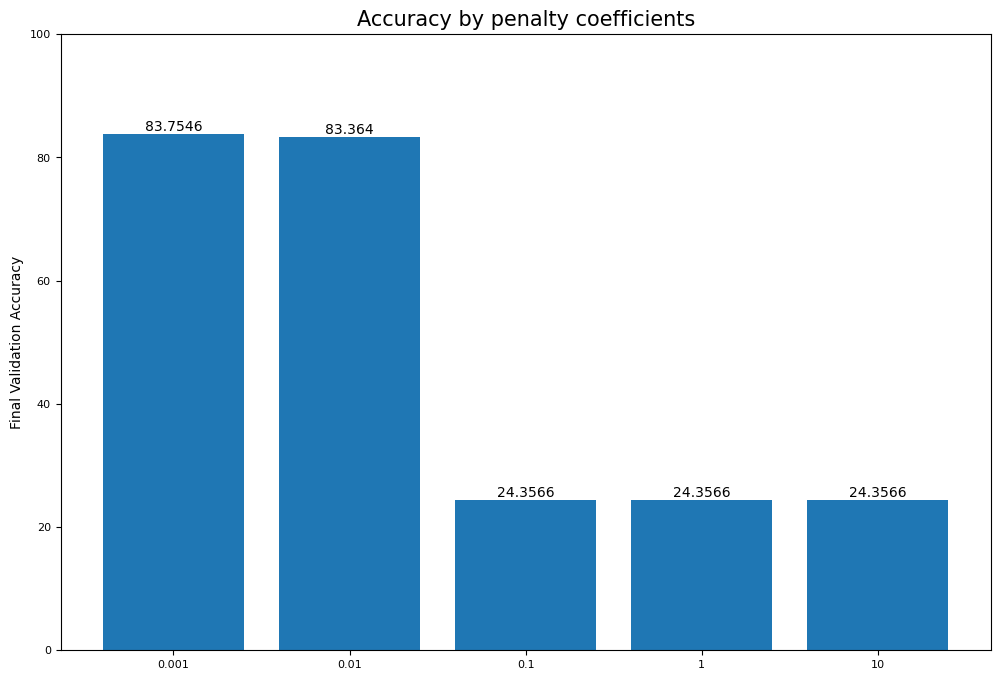

optimal penalty coefficient is 0.001


In [20]:
final_acc = []

best_acc = 0

for l2 in l2_vals:
    
    l2_reg = l2

    model1, criterion1, optimiser1 = get_model(x_train, f1, f2, k1, k2, pool_size, stride_pool, classes)

    history1 = training_loop(model1, criterion1, optimiser1, train_loader, val_loader, 2000, 150, printer=False, l2_reg = l2)
    
    final_acc.append(history1['validation_accuracy'][-1])
    val_acc = history1['validation_accuracy'][-1]
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_l2 = l2
    
fig, ax = plt.subplots(figsize=(12, 8))

names = ['0.001', '0.01', '0.1', '1', '10']

bars = ax.bar(names, final_acc)

ax.bar_label(bars)

ax.set_ylabel('Final Validation Accuracy')
ax.set_title('Accuracy by penalty coefficients')
ax.set_ylim(0, 100)
plt.show()

print(f'optimal penalty coefficient is {best_l2}')

We see that the for values between 0.1 and 10, $L_{2}$ Regularisation constalntly shows very poor performance with almost the exact same final validation accuracy and quick early stopping. In order to see proper results, we need to set the penalty coefficient lower. For 0.001 and 0.01, we see huge improvement in performance and there is no longer early stopping. Theoretically, 0.001 should show higher accuracy than 0.01 due to less bias. However, due to randomness, there cases where 0.01 shows higher accuracy.

Now re-train the CNN on the training set using the optimal $L_{2}$ coefficient.

In [21]:
model_opt_l2, criterion_opt_l2, optimiser_opt_l2 = get_model(x_train, f1, f2, k1, k2, pool_size, stride_pool, classes)

In [22]:
history_opt_l2 = training_loop(model_opt_l2, criterion_opt_l2, optimiser_opt_l2, train_loader, val_loader, 2000, 150, printer=True, l2_reg = best_l2)

Epoch 1/2000, Training loss: 1.3864471912384033, Training accuracy: 23.904718137254903%, Validation loss: 1.3860634565353394, Validation accuracy: 22.794117647058822%
Epoch 201/2000, Training loss: 1.2201570868492126, Training accuracy: 50.337009803921575%, Validation loss: 1.2390702366828918, Validation accuracy: 50.873161764705884%
Epoch 401/2000, Training loss: 1.1467780470848083, Training accuracy: 63.43826593137255%, Validation loss: 1.1529165506362915, Validation accuracy: 60.66176470588236%
Epoch 601/2000, Training loss: 1.106245219707489, Training accuracy: 65.30330882352942%, Validation loss: 1.1204125881195068, Validation accuracy: 62.22426470588236%
Epoch 801/2000, Training loss: 1.0834893584251404, Training accuracy: 69.93336397058823%, Validation loss: 1.0969916582107544, Validation accuracy: 66.72794117647058%
Epoch 1001/2000, Training loss: 1.0621947348117828, Training accuracy: 71.11289828431373%, Validation loss: 1.0794038772583008, Validation accuracy: 68.589154411764

Evaluate the classification accuracy on the test set.

In [23]:
t_a_opt_l2 = test_acc(model_opt_l2, testing_loader)

The classification accuracy on the test set is 0.7790670955882353


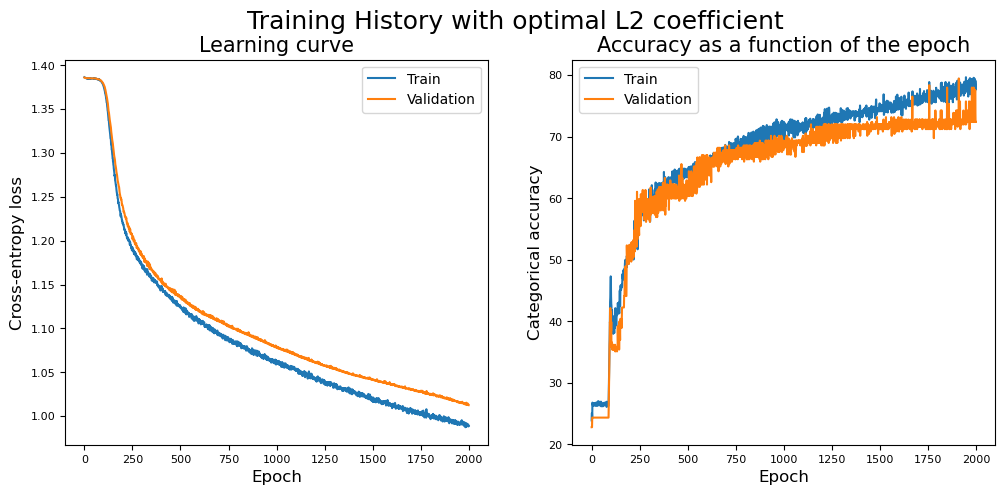

In [24]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle("Training History with optimal L2 coefficient", fontsize=18)

fig.add_subplot(121)
plt.plot(history_opt_l2['training_loss'], label='Train')
plt.plot(history_opt_l2['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history_opt_l2['training_accuracy'], label='Train')
plt.plot(history_opt_l2['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

The model with $L_{2}$ Regularisation shows a more difference in the training and validation.

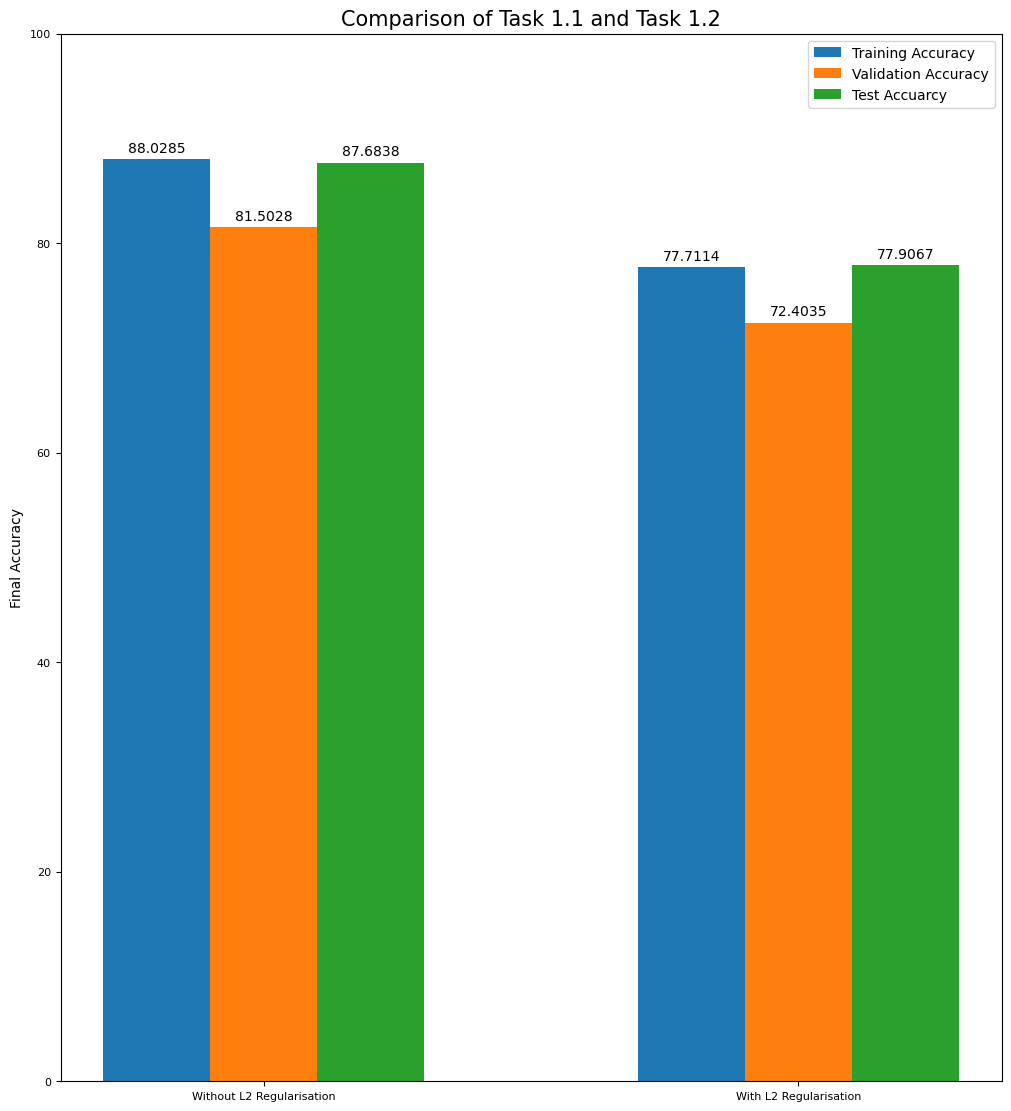

In [25]:
title_list = ("Without L2 Regularisation", "With L2 Regularisation")
compare_means = {
    'Training Accuracy': (history['training_accuracy'][-1],history_opt_l2['training_accuracy'][-1]),
    'Validation Accuracy': (history['validation_accuracy'][-1],history_opt_l2['validation_accuracy'][-1]),
    'Test Accuarcy': (t_a * 100, t_a_opt_l2 * 100)
}

x = np.arange(len(title_list))  # the label locations
width = 0.20  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize = (10, 11), layout='constrained')

for attribute, measurement in compare_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Final Accuracy')
ax.set_title('Comparison of Task 1.1 and Task 1.2')
ax.legend()
ax.set_ylim(0, 100)
ax.set_xticks(x + width, title_list)

plt.show()


As we can see from the bar plot above, the model with $L_{2}$ Regularisation shows less accuracy than the the model without $L_{2}$ Regularisatio,n which was expected given the nature of $L_{2}$ Regularisation.(not unbiased)



---



<a name="task-13"></a>

## (1.3) [(index)](#index-task-12)

Create the imbalanced training set by randomly dropping half of the data points in class 3 from the original training set.

In [26]:
class_3_indices = np.where(Y_train == 3)[0]

# Randomly drop half of the indices
np.random.seed(0)
class_3_indices_to_drop = np.random.choice(class_3_indices, size=len(class_3_indices) // 2, replace=False)

# Remove dropped indices from the data
remaining_indices = np.setdiff1d(np.arange(len(Y_train)), class_3_indices_to_drop)
imb_X_train = X_train[remaining_indices]
imb_Y_train = Y_train[remaining_indices]

Split the imbalanced training set.

In [27]:
imbx_train, imbx_val, imby_train, imby_val = set_split(imb_X_train, imb_Y_train)

Created the data loaders for imbalanced training and validation sets.

In [28]:
imbtrain_loader = data_loader(imbx_train, imby_train, shuffle=True)
imbval_loader = data_loader(imbx_val, imby_val, shuffle=False)

In [29]:
model_imb, criterion_imb, optimiser_imb = get_model(imbx_train, f1, f2, k1, k2, pool_size, stride_pool, classes)

In [30]:
history_imb = training_loop(model_imb, criterion_imb, optimiser_imb, imbtrain_loader, imbval_loader, 2000, 150, printer=False)

Early stopping acting.


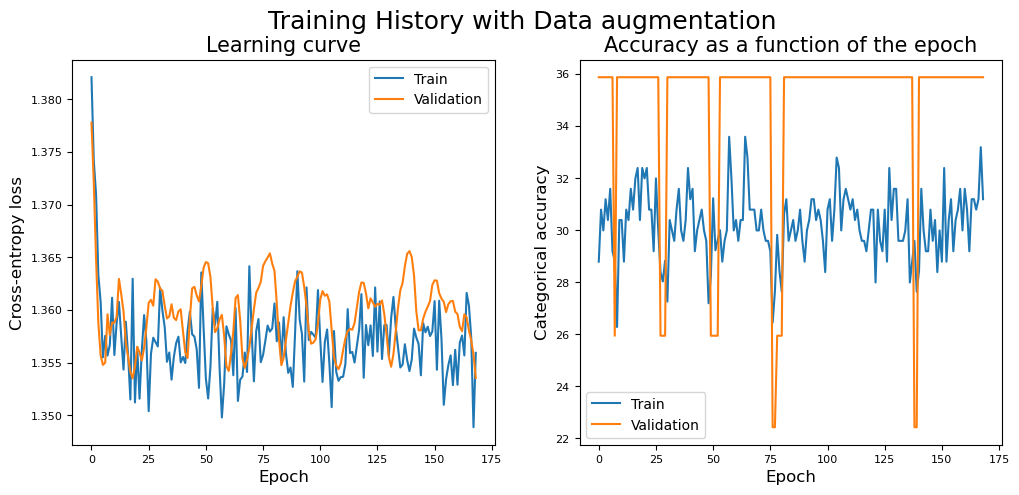

In [31]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle("Training History with Data augmentation", fontsize=18)

fig.add_subplot(121)
plt.plot(history_imb['training_loss'], label='Train')
plt.plot(history_imb['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history_imb['training_accuracy'], label='Train')
plt.plot(history_imb['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

We can see that the model does not do a good job.

In [32]:
t_a_imb = test_acc(model_imb, testing_loader)

The classification accuracy on the test set is 0.266390931372549


The accuracy on the test of this re-trained CNN model is very low which means that the performance of the model is poor.

`get_model_w` is `get_model` with a reweighted loss function.

In [33]:
def get_model_w(x_train, f1, f2, k1, k2, pool_size, stride_pool, classes):
    """
    CNN model in PyTorch:
    - Layers are Conv1d(+ReLU), MaxPool1d, Flatten and Linear(+Softmax).
    - It features an Adam optimiser and CrossEntropyLoss criterion.
    - Conv1d and Linear layers have regularised weights according to l2_reg.

    Parameters:
    x_train: Training data
    n_filters: Number of filters to be used in the convolutional layer
    k: Kernel size in the convolutional layer
    pool_size: MaxPool1d window size
    stride_pool: Stride of the MaxPool1d sliding window
    classes: List containing the output classes

    Returns:
    Model, criterion and optimiser.

    """
    
    model = Sequential(
        Conv2d(1, f1, kernel_size=(k1, k1)),
        ReLU(),
        MaxPool2d(kernel_size=(pool_size, pool_size), stride=stride_pool),
        Conv2d(f1, f2, kernel_size=(k2, k2)),
        ReLU(),
        Flatten(),
        Linear(f2 * ((x_train.shape[1] - k1 + 1) // pool_size - k2 + 1) ** 2, len(classes)),
        Softmax(dim=1),
    )
    
    class_weights = torch.FloatTensor([1, 1, 1, 2])
    criterion = CrossEntropyLoss(weight=class_weights)
    optimiser = torch.optim.Adam(model.parameters())

    return model, criterion, optimiser

In [34]:
model_w, criterion_w, optimiser_w = get_model_w(imbx_train, f1, f2, k1, k2, pool_size, stride_pool, classes)

In [35]:
history_w = training_loop(model_w, criterion_w, optimiser_w, imbtrain_loader, imbval_loader, 2000, 150)

Epoch 1/2000, Training loss: 1.3866262435913086, Training accuracy: 18.424479166666664%, Validation loss: 1.3864850997924805, Validation accuracy: 25.948660714285715%
Epoch 201/2000, Training loss: 1.1654298603534698, Training accuracy: 60.60267857142857%, Validation loss: 1.1473035216331482, Validation accuracy: 61.43973214285714%
Epoch 401/2000, Training loss: 1.080314725637436, Training accuracy: 63.69977678571428%, Validation loss: 1.071435034275055, Validation accuracy: 63.39285714285714%
Epoch 601/2000, Training loss: 1.0141242146492004, Training accuracy: 76.86941964285714%, Validation loss: 1.0403021574020386, Validation accuracy: 69.30803571428572%
Epoch 801/2000, Training loss: 0.9748400747776031, Training accuracy: 79.62239583333334%, Validation loss: 1.0180619955062866, Validation accuracy: 73.66071428571428%
Epoch 1001/2000, Training loss: 0.9520943313837051, Training accuracy: 82.36607142857143%, Validation loss: 1.0056857466697693, Validation accuracy: 76.39508928571428%

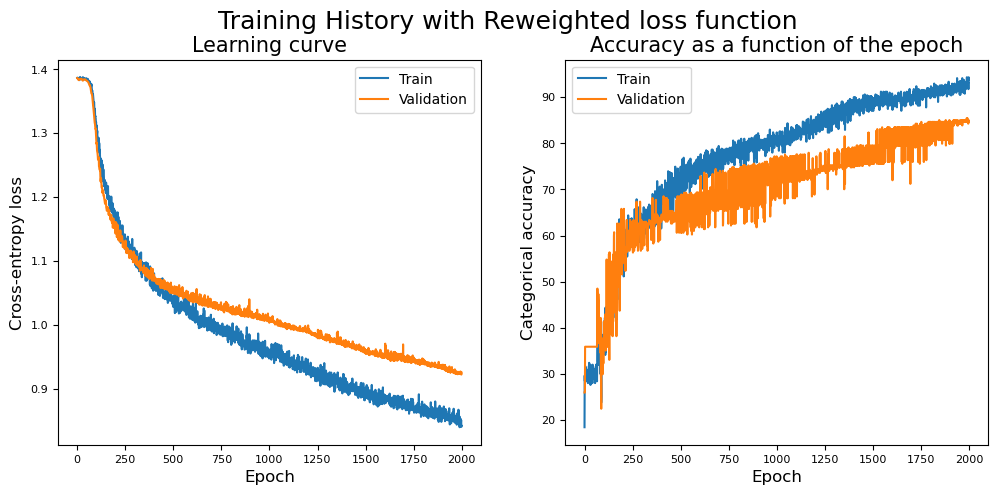

In [36]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle("Training History with Reweighted loss function", fontsize=18)

fig.add_subplot(121)
plt.plot(history_w['training_loss'], label='Train')
plt.plot(history_w['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history_w['training_accuracy'], label='Train')
plt.plot(history_w['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

In [37]:
t_a_w = test_acc(model_w, testing_loader)

The classification accuracy on the test set is 0.9071308210784313


We see a clear improvement over the model without the reweighted loss function.

`data_augmentation` produces new training data of the minority class by using the depleted class 3.

In [38]:
def data_augmentation(imbx, imby, c):

    class_3_indices = np.where(imby == 3)[0]
    
    mat_var = c * np.var(imbx[class_3_indices], axis=0)
    # Calculate the variance of pixel values across the images in class 3

    augmented_images_class_3 = []

    for index in class_3_indices:
        original_image = imbx[index].copy()
        noise = np.zeros((32, 32))
        # Add Gaussian noise to each pixel
        for i in range(32):
            for j in range(32):
                noise[i, j] = np.random.normal(scale=np.sqrt(mat_var[i, j]))
                
        augmented_image = original_image + noise

        # Append the augmented image to the list
        augmented_images_class_3.append(augmented_image)

    new_classes_class_3 = np.full(len(augmented_images_class_3), 3)
    
    reb_data_images_train = np.concatenate((imbx, augmented_images_class_3), axis=0)
    reb_data_classes_train = np.concatenate((imby, new_classes_class_3), axis=0)
    
    return reb_data_images_train, reb_data_classes_train

Create the augmented data set

In [39]:
x_aug_1, y_aug_1 = data_augmentation(imb_X_train, imb_Y_train, 0.01)

Split the augmented data set

In [40]:
xaug_1, xaug_t1, yaug_1, yaug_t1 = set_split(x_aug_1, y_aug_1)

In [41]:
c_vals = [0.01, 0.1, 1]

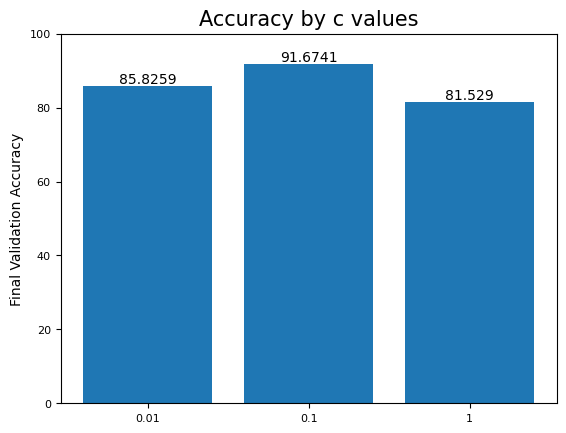

optimal value for c is 0.1


In [42]:
final_acc_c = []

best_acc_c = 0

for c in c_vals:
    
    x_aug_1, y_aug_1 = data_augmentation(imb_X_train, imb_Y_train, c)
    
    xaug_1, xaug_t1, yaug_1, yaug_t1 = set_split(x_aug_1, y_aug_1)
    
    model_aug_1, criterion_aug_1, optimiser_aug_1 = get_model(xaug_1, f1, f2, k1, k2, pool_size, stride_pool, classes)
    
    augtrain_loader = data_loader(xaug_1, yaug_1, shuffle=True)
    augval_loader = data_loader(xaug_t1, yaug_t1, shuffle=False)
    
    history2 = training_loop(model_aug_1, criterion_aug_1, optimiser_aug_1, augtrain_loader, augval_loader, 2000, 150, printer=False)
    
    final_acc_c.append(history2['validation_accuracy'][-1])
    val_acc = history2['validation_accuracy'][-1]
    
    if val_acc > best_acc_c:
        best_acc_c = val_acc
        best_c = c
    
fig, ax = plt.subplots()

names_c = ['0.01', '0.1', '1']

bars = ax.bar(names_c, final_acc_c)

ax.bar_label(bars)

ax.set_ylabel('Final Validation Accuracy')
ax.set_title('Accuracy by c values')
ax.set_ylim(0, 100)

plt.show()

print(f'optimal value for c is {best_c}')

In [43]:
x_aug_2, y_aug_2 = data_augmentation(imb_X_train, imb_Y_train, best_c)
xaug_2, xaug_t2, yaug_2, yaug_t2 = set_split(x_aug_2, y_aug_2)
augtrain_loader_2 = data_loader(xaug_2, yaug_2, shuffle=True)
augval_loader_2 = data_loader(xaug_t2, yaug_t2, shuffle=False)

In [44]:
model_aug_opt, criterion_aug_opt, optimiser_aug_opt = get_model(xaug_2, f1, f2, k1, k2, pool_size, stride_pool, classes)

In [45]:
history_aug_opt = training_loop(model_aug_opt, criterion_aug_opt, optimiser_aug_opt, augtrain_loader_2, augval_loader_2, 2000, 150)

Epoch 1/2000, Training loss: 1.3861623704433441, Training accuracy: 26.14889705882353%, Validation loss: 1.385819435119629, Validation accuracy: 20.814732142857142%
Epoch 201/2000, Training loss: 1.2190235555171967, Training accuracy: 50.145526960784316%, Validation loss: 1.1982784867286682, Validation accuracy: 52.90178571428572%
Epoch 401/2000, Training loss: 1.1158011555671692, Training accuracy: 64.61014093137256%, Validation loss: 1.1107558608055115, Validation accuracy: 59.55357142857143%
Epoch 601/2000, Training loss: 1.0684637129306793, Training accuracy: 71.21629901960785%, Validation loss: 1.077956736087799, Validation accuracy: 67.61160714285714%
Epoch 801/2000, Training loss: 1.0411394536495209, Training accuracy: 73.31495098039215%, Validation loss: 1.0546844601631165, Validation accuracy: 66.96428571428572%
Epoch 1001/2000, Training loss: 1.0229916125535965, Training accuracy: 73.70174632352942%, Validation loss: 1.0465629398822784, Validation accuracy: 68.00223214285714%

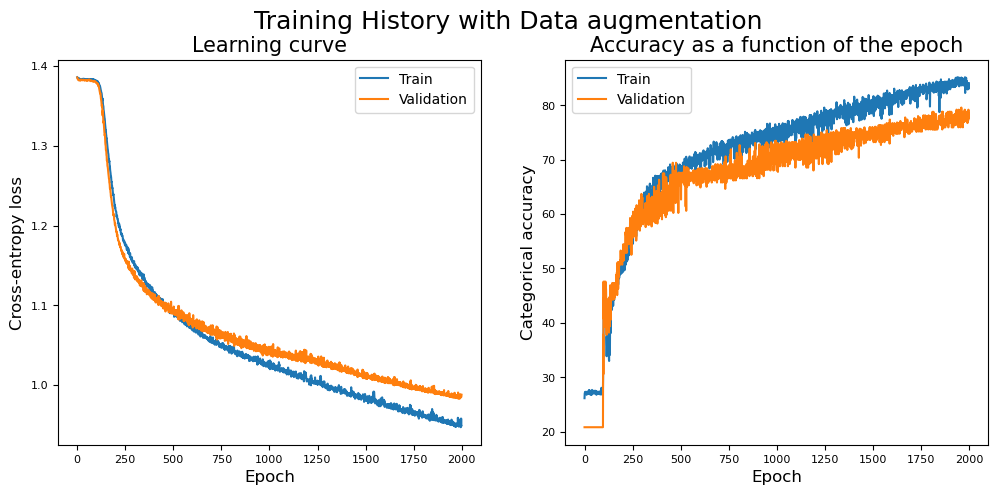

In [46]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle("Training History with Data augmentation", fontsize=18)

fig.add_subplot(121)
plt.plot(history_aug_opt['training_loss'], label='Train')
plt.plot(history_aug_opt['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history_aug_opt['training_accuracy'], label='Train')
plt.plot(history_aug_opt['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

Evaluate the accuracy on the test set.

In [47]:
t_a_aug_opt = test_acc(model_aug_opt, testing_loader)

The classification accuracy on the test set is 0.8162147671568627


The Data Augmentation also shows much better accuracy than the raw model.

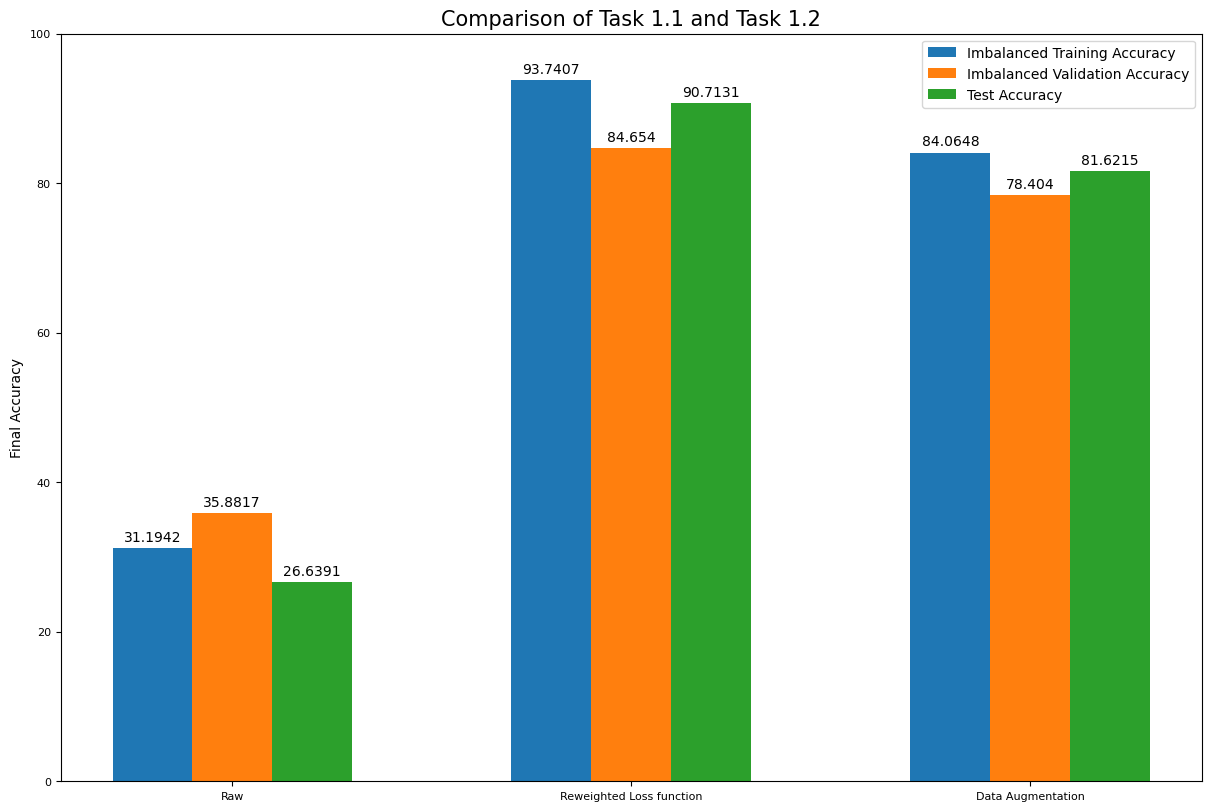

In [48]:
title_list_2 = ("Raw", "Reweighted Loss function", "Data Augmentation")
compare_means_2 = {
    'Imbalanced Training Accuracy': (history_imb['training_accuracy'][-1],history_w['training_accuracy'][-1], history_aug_opt['training_accuracy'][-1]),
    'Imbalanced Validation Accuracy': (history_imb['validation_accuracy'][-1],history_w['validation_accuracy'][-1], history_aug_opt['validation_accuracy'][-1]),
    'Test Accuracy':(t_a_imb * 100, t_a_w * 100, t_a_aug_opt * 100)
}

x = np.arange(len(title_list_2))  # the label locations
width = 0.20  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize = (12, 8), layout='constrained')

for attribute, measurement in compare_means_2.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Final Accuracy')
ax.set_title('Comparison of Task 1.1 and Task 1.2')
ax.legend()
ax.set_ylim(0, 100)
ax.set_xticks(x + width, title_list_2)

plt.show()


We can immediately see that the model without any implications does significantly worse than the Reweighted loss function and Data Augmentation. For Reweighted loss function and Data Augmentation, for this specific iteration, the Reweighted loss function had a better performance. However, there were occasions where Reweighted loss function showed slightly worse performance. Therefore, we can conclude that Reweighted Loss function and Data Augmentation are both good methods.



---



<a name="task-2"></a>

# (2) Task 2: Dimensionality Reduction: PCA vs ISOMAP [(index)](#index-task-2)

<a name="task-21"></a>

## (2.1) [(index)](#index-task-21)

In [49]:
X_train = np.load('star_images_train.npy')
Y_train = np.load('star_classes_train.npy')

x_testing = np.load('star_images_test.npy')
y_testing = np.load('star_classes_test.npy')

x_emb = np.load('star_embeddings_train.npy')

In [50]:
def standardise(X):
    mu = np.mean(X, 0)
    sigma = np.std(X, 0)
    X_std = (X - mu) / sigma
    return X_std

In [51]:
X_norm = standardise(x_emb)

In [52]:
def covariance_matrix(X):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.

    Returns:
    Xbar: Computes the data covariance matrix.

    """
    return np.dot(X.T, X) / len(X)

def pca_function(X, k):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.
    k: Number of principal components.

    Returns:
    X_pca: Transformed data.
    eigenvectors: First k eigenvectors of C.
    eigenvalues: First k eigenvalues of C.

    """
    # Computing the covariance matrix
    C = covariance_matrix(X)

    # Computing the eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, k, which='LM', return_eigenvectors=True)

    # Sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_index]
    eigenvectors = eigenvectors[:,sorted_index]

    # Projecting the data onto the directions of eigenvectors
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

Perform PCA of the standardised embedding vectors

In [53]:
X_pca, eigenvectors, eigenvalues = pca_function(X_norm, 2)

In [54]:
embedding_pca = np.dot(X_norm, eigenvectors)

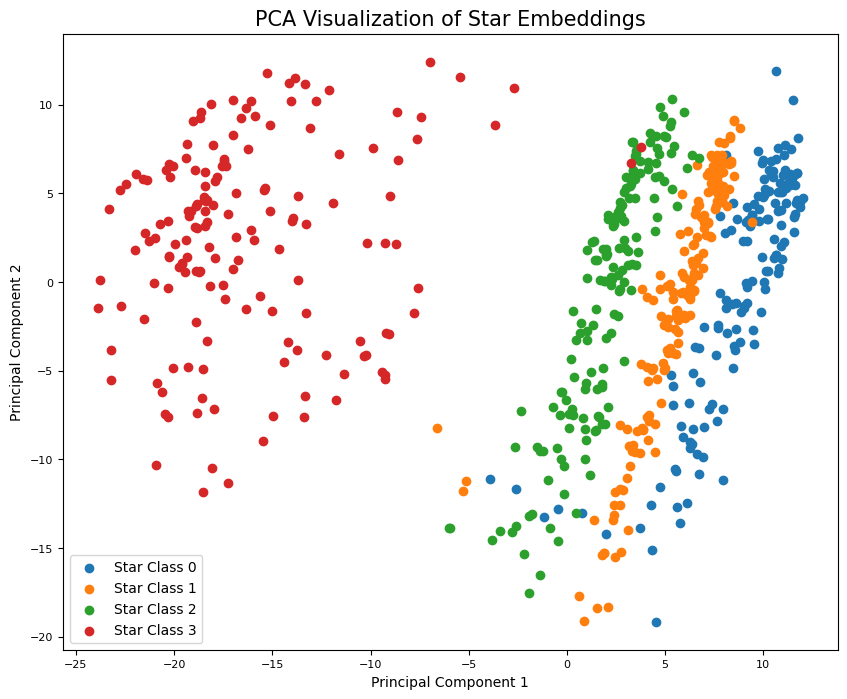

In [55]:
plt.figure(figsize=(10, 8))
for star_class in np.unique(Y_train):
    indices = np.where(Y_train == star_class)[0]
    plt.scatter(embedding_pca[indices, 0], embedding_pca[indices, 1], label=f'Star Class {star_class}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Star Embeddings')
plt.legend()
plt.show()

A 2d visualisation of the first two principal components of PCA of embedding.
As we can see from the plot, star class M5V is isolated and the other classes(O5V, A0V, F5V) are close to each other.

Now we define `compute_centroids` which computes the centorids of the clustered points in embeddings.

In [56]:
def compute_centroids(X, Y, classes):
    """
    Compute the centroids of the clustered points X.

    Args:
        X (np.ndarray): data points, with shape (N, p)
        labels (list): cluster assignments for each sample in X, with shape (N,).

    Returns:
    """
    
    centroids = []

    for i in range(len(classes)):
        ind = np.where(Y == i)[0]
        cluster_X_i = X[ind]
        centroids.append(cluster_X_i.mean(axis=0))

    return centroids

In [57]:
centroids = compute_centroids(embedding_pca, Y_train, classes)

In [58]:
centroids

[array([ 8.747999  , -0.24031985], dtype=float32),
 array([ 5.5630665, -1.195692 ], dtype=float32),
 array([ 1.9947162 , -0.79987556], dtype=float32),
 array([-16.221632 ,   2.3140736], dtype=float32)]

We now have the coordinates for the 4 different centroids for 4 classes.

In [59]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((np.array(point2) - np.array(point1))**2))

In [60]:
def avg_distance(X, Y, centroids):
    """
    Compute the centroids of the clustered points X.

    Args:
        X: embedding.
        Y: class values to distinguish the points.

    Returns:
    average: list of average distance between points in the cluster and the centroid of that cluster.
    """
    average = []
    
    for i in range(len(centroids)):
        ind = np.where(Y == i)[0]
        
        cluster_X_i = X[ind]
        
        dis = np.sqrt(((cluster_X_i - centroids[i])**2).sum(axis = 1))
        
        average.append(np.mean(dis))

    return average

In [61]:
s = avg_distance(embedding_pca, Y_train, centroids)

List of $S_{\alpha}$

In [62]:
s

[6.040741, 6.031098, 6.3780704, 6.4872675]

Define `db_ind` which calculates the Davies-Bouldin Index.

In [63]:
def db_ind(X, Y, centroids, s):
    db_index = 0
    for i in range(len(centroids)):
        max_ratio = 0
        for j in range(len(centroids)):
            if i != j:
                ratio = ((s[i] + s[j]) / euclidean_distance(centroids[i], centroids[j]))
                if ratio > max_ratio:
                    max_ratio = ratio
        db_index += max_ratio
        
    db_index = db_index / len(centroids)
    
    return db_index

In [64]:
db_ind(embedding_pca, Y_train, centroids, s)

2.853369504213333

High Davies-Bouldin Index means that the within distance for each cluster is big while the distance between the centorids of the clusters are small. On the other hand, low Davies-Bouldin Index means taht the within distance is small and the distance between the centroids are big. Therefore, we can conclude that a lower Davies-Bouldin Index indicates that we have better clustering.

Comparing the distances between centroids and the Davies-bouldin Index value of embedding in the 2D space of the first two principal components of PCA, we can say that the clustering quality is good.

We will further discuss the meaning of Davies-Bouldin Index in Question 2.3



---



<a name="task-22"></a>

## (2.2) [(index)](#index-task-22)

Define `Dij_calc` which calculates the cosine distance matrix $D$.

In [65]:
def Dij_calc(embeddings):
    # compute dot product of each pair of embedding vectors
    dot_products = np.dot(embeddings, embeddings.T)

    # compute norms of each embedding vector
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)

    # compute pairwise cosine distances
    Dij_calc = dot_products / (norms * norms.T)

    # compute distances (1 - D) and set diagonal all diagonal entries to 0
    pairwise_distances = 1 - Dij_calc
    np.fill_diagonal(pairwise_distances, 0)

    return pairwise_distances


In [66]:
Dij = Dij_calc(x_emb)

In [67]:
Dij

array([[0.        , 0.01824152, 0.02551126, ..., 0.04226905, 0.01094103,
        0.00847834],
       [0.01824152, 0.        , 0.03291142, ..., 0.04069829, 0.01832455,
        0.01253992],
       [0.02551126, 0.03291142, 0.        , ..., 0.00355619, 0.00990593,
        0.03279209],
       ...,
       [0.04226905, 0.04069829, 0.00355619, ..., 0.        , 0.01707655,
        0.04841429],
       [0.01094103, 0.01832455, 0.00990593, ..., 0.01707655, 0.        ,
        0.02273381],
       [0.00847834, 0.01253992, 0.03279209, ..., 0.04841429, 0.02273381,
        0.        ]], dtype=float32)

Define `kNN` which constructs the adjacency matrix $A$ of the $k$-Nearset Neighbour graph.

In [68]:
def kNN(pairwise_distances, k):
    # Sort the cosine distance matrix for each row to find k-nearest neighbors
    sorted_indices = np.argsort(pairwise_distances, axis=1)

    num_nodes = pairwise_distances.shape[0]
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    # Construct the adjacency matrix
    for i in range(num_nodes):
        for j in range(1, k + 1):  # Exclude the node itself (j=0)
            neighbor_index = sorted_indices[i, j]
            adjacency_matrix[i, neighbor_index] = pairwise_distances[i, neighbor_index]
            adjacency_matrix[neighbor_index, i] = pairwise_distances[i, neighbor_index]  # Undirected graph

    return adjacency_matrix

k = 9
A = kNN(Dij_calc(x_emb), k)

In [69]:
_, evectors, evalues = pca_function(x_emb, 2)

Define degree vector $d = A1^{T}$

In [70]:
d = (A @ np.ones((A.shape[1], 1))).flatten()

Now we perform spectral analysis of symmetric normalise Laplacian.


$$L_\text{sym}=D^{-1/2} L D^{-1/2}$$

where $L=D-A$

In [71]:
D = np.diag(d)

L = D - A

# compute square root of inverse diagonal degree matrix
D_sqrt_inv = np.diag(1/np.sqrt(d))

# compute symmetric normalised Laplacian
L_s = D_sqrt_inv @ L @ D_sqrt_inv

In [72]:
eigenvals, eigenvecs = np.linalg.eigh(L_s)

# sort eigenvalues and corresponding eigenvector
eigenvecs = eigenvecs.T[np.argsort(eigenvals)]
eigenvals = np.sort(eigenvals)

v2 = eigenvecs[1]
v3 = eigenvecs[2]

# normalise coordinates\
x = D_sqrt_inv @ v2
y = D_sqrt_inv @ v3

In [73]:
L

array([[ 0.015374  ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.01243383,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.03756666, ..., -0.00355619,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        , -0.00355619, ...,  0.03769588,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.03258657,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.02139223]])

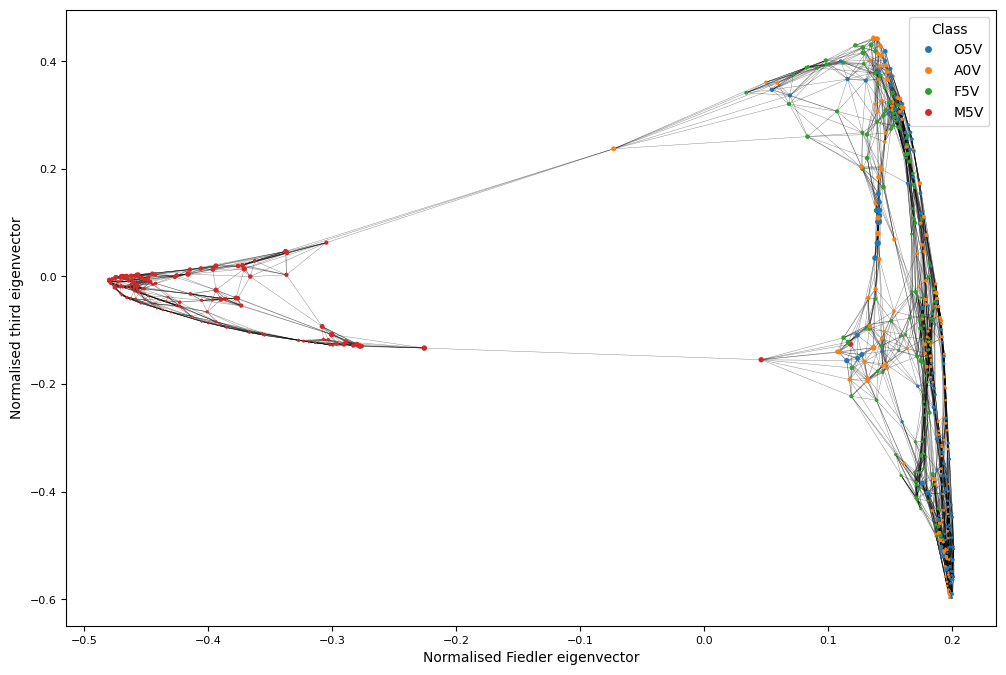

In [74]:
cmap = matplotlib.colormaps.get_cmap('tab10')
color_type = [cmap(i) for i in Y_train]

value_to_type = {0: 'O5V', 1: 'A0V', 2: 'F5V', 3: 'M5V'}

fig, ax = plt.subplots(1, figsize=(12, 8))

N = 648
# plot edges
for i in range(N):
    for j in range(i+1,N):
        if A[i,j] > 0:
            ax.plot([x[i],x[j]],[y[i],y[j]], color="black", alpha=0.5, linewidth=0.3)

# plot nodes
scatter = ax.scatter(x,y,s=100 * d, c=color_type, zorder=10)

# create legend for node types
types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=cmap(value)) for value, label in value_to_type.items()]
plt.legend(handles=types_legend, title='Class')

# set labels
ax.set(xlabel="Normalised Fiedler eigenvector", ylabel="Normalised third eigenvector")
plt.show()

We can immediately see that the class 'M5V' data points form their own group and are isolated from other class type data points.

It is hard to see a clear pattern for the classes 'O5V', 'A5V', 'F5V'. Therefore, a good clustering algorithm will be decided by the algorithm's performance of distinguishing these class types.



---



<a name="task-22"></a>

## (2.3) [(index)](#index-task-23)

In [75]:
def compute_resistance_distance(L):
    # Number of nodes
    N = L.shape[0]

    # Compute Z
    Z = np.ones((N, 1))

    # Compute G
    G = np.linalg.pinv(L - (1 / N) * Z @ Z.T)

    # Compute resistance distance matrix R
    R = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            R[i, j] = G[i, i] + G[j, j] - 2 * G[i, j]

    return R

R = compute_resistance_distance(L)

In [76]:
mean_D = Dij.mean(axis=0)

In [77]:
mean_R = R.mean(axis=0)

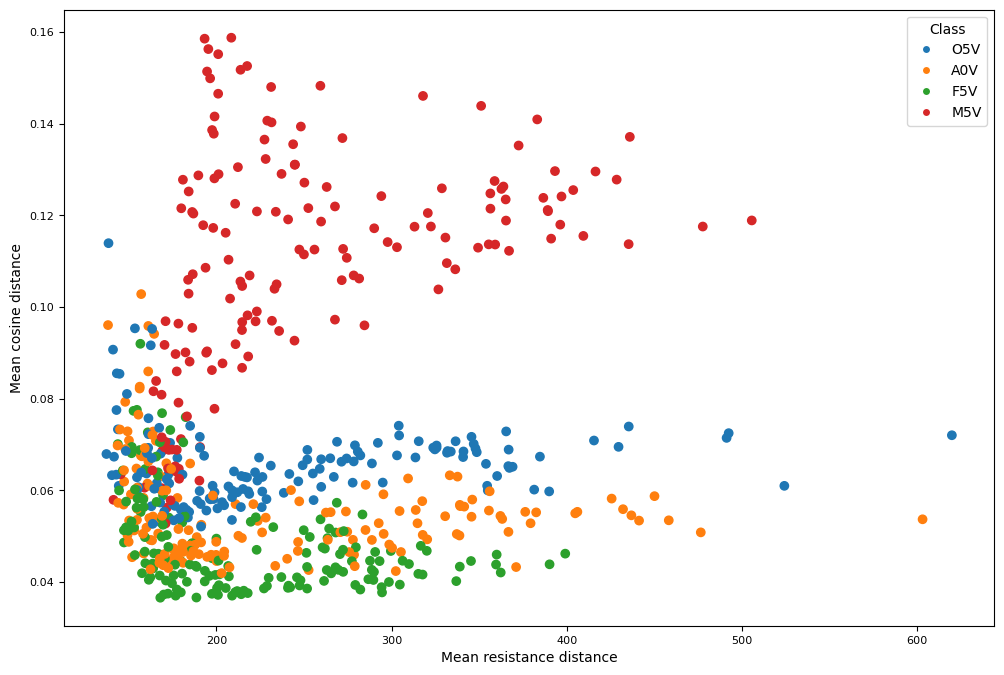

In [78]:
fig, ax = plt.subplots(1, figsize=(12, 8))

scatter = ax.scatter(mean_R, mean_D, c=color_type, zorder=10)

# create legend for node types
types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=cmap(value)) for value, label in value_to_type.items()]
plt.legend(handles=types_legend, title='Class')

# set labels
ax.set(xlabel="Mean resistance distance", ylabel="Mean cosine distance")
plt.show()

Again, we can see the group of class 'M5V' data points are isolated from the rest. We also notice that class 'M5V' show much more variance in cosine distance compared to other class types.

In [79]:
def centred_distance(R):
    
    N = R.shape[0]

    # Compute Z
    Z = np.ones((N, 1))

    # Compute G
    H = np.identity(N) - (1 / N) * Z @ Z.T

    # Compute resistance distance matrix R
    S = np.square(R)
    
    tau = - H @ S @ H / 2

    return tau

In [80]:
tau = centred_distance(R)

In [81]:
eval_tau, evec_tau = np.linalg.eigh(tau)

In [82]:
sorted_tau = np.argsort(eval_tau)[::-1][0:2]
eval_tau = eval_tau[sorted_tau] # <-- SOLUTION
evec_tau = evec_tau[:,sorted_tau] # <-- SOLUTION

In [83]:
imp_tau = evec_tau

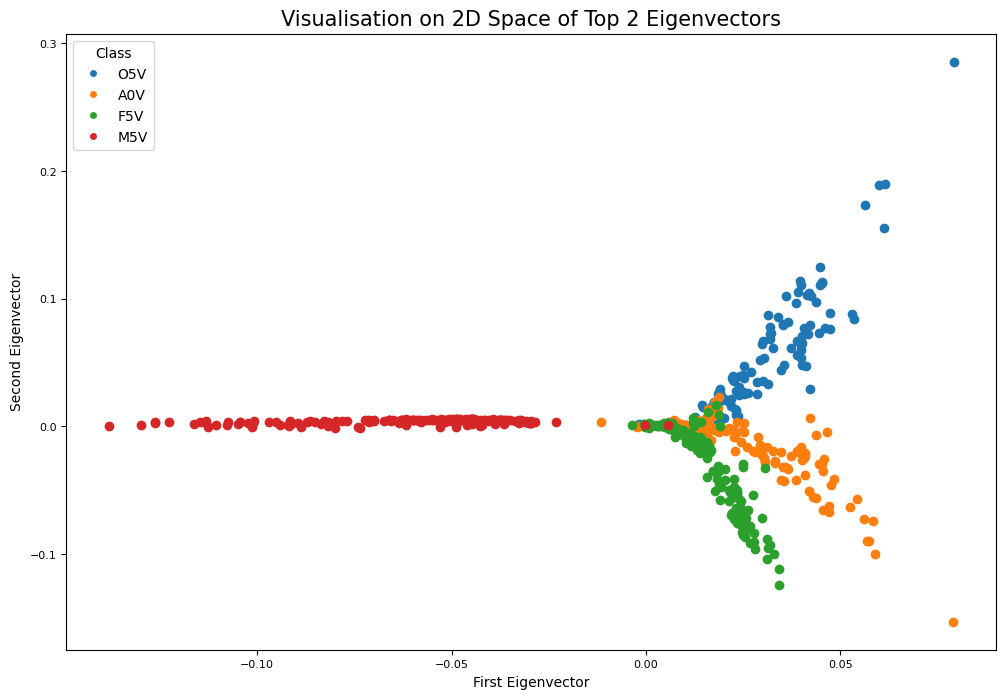

In [84]:
fig, ax = plt.subplots(1, figsize=(12, 8))

for star_class in np.unique(Y_train):
    indices = np.where(Y_train == star_class)[0]
    ax.scatter(imp_tau[indices, 0], imp_tau[indices, 1])
    
types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=cmap(value)) for value, label in value_to_type.items()]
plt.legend(handles=types_legend, title='Class')

plt.xlabel('First Eigenvector')
plt.ylabel('Second Eigenvector')
plt.title('Visualisation on 2D Space of Top 2 Eigenvectors')
plt.show()

In [85]:
centroids_tau = compute_centroids(imp_tau, Y_train, classes)
s_tau = avg_distance(imp_tau, Y_train, centroids_tau)

In [86]:
db_ind(imp_tau, Y_train, centroids_tau, s_tau)

1.9387931870999802

As we can see from the plot and the low Davies-Bouldin Index value, the Isomap-like algorithm also does a good job of clustering.

Now we compare the 2D representation obtained from PCA in Task 2.1 and the 2D representation obtained from the Isomap-like algorithm from Task 2.3

We discussed in Task 2.1 that lower Davies-Bouldin Index value means better quality clustering. \
Minimising the $DB$ index value is essentailly equavalent to minimising,

$$\sum_{\alpha=1}^{C} max_{\beta, \beta\neq\alpha} F_{\alpha\beta}$$

$$F_{\alpha\beta} = \frac{S_{\alpha} + S_{\beta}}{M_{\alpha\beta}}$$

Since we are summing over the maximum value of $F_{\alpha\beta}$, in order to get a minimise $DB$ index value, we want to seperate the clusters that are close to each other(class 'O5V', 'A5V', 'F5V' for our case) as much as we can(i.e. increase $M_{\alpha\beta}$ value).

We notice that this analysis agrees well with the comparison of $DB$ index values of the two different algorithms and the obeserved differences in the 2D representations.

Looking at the two plots, we know that both algorithms do a good job of seperating class 'M5V' from the rest. However, in the 2D representation of the top two eigenvectors of $\tau$, we see that the class 'O5V', 'A5V', 'F5V' data points are clustered well because the three clusters ared spreading in three different directionos.

In conclusion, the Isomap-like algorithm does a better job of increasing the $M_{\alpha\beta}$ values, which leads to having a lower Davies-Bouldin Index value. 



---

